In [1]:
wd <- dirname(dirname(getwd()))
source(paste0(wd,"/mission_control/treasure_map.R"))
source(paste0(wd,"/mission_control/helpers/figures/figure5_themes.R"))

library(tidyverse)
library(RColorBrewer)
library(gridExtra)
library(ggpubr)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  3.1.2     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ dplyr   1.0.6
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  3.1.2     ✔ forcats 0.5.1
Warning message:
“package ‘tibble’ was built under R version 3.6.3”Warning message:
“package ‘tidyr’ was built under R version 3.6.3”Warning message:
“package ‘purrr’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”Warning message:
“package ‘forcats’ was built under R version 3.6.3”── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The followin

### 0 - Read in HMF validation data

In [2]:
validation_ready <- readRDS(paste0(TMP_DIR, "validation-hmf-go.Rds"))
hmf_loo <- readRDS(paste0(TMP_DIR, "validation-loo-cv.Rds")) #%>% drop_na(tcell)
ee <- validation_ready %>% left_join(hmf_loo, by = "patient_id")
ee <- ee %>% drop_na(pred_lr) %>% drop_na(tcell)

#### Should all be in validation-go prep

In [3]:
ee$tissue <- factor(
    ee$tissue,
    levels = c("Skin", "Lung", "Bladder", "Other")
)
ee$pan <- "Pan-Cancer"

ee$lr_gp <-  cut( ee$pred_lr,  breaks = c(0,.1,.5,    1) , labels = c("Low", "Medium", "High"))
ee$os_gp2 <-  ifelse( ee$os_gp == "High", "High","Low")

In [4]:
ee$low_alpha = ifelse( ee$os_gp2 == "Low" & ee$lr_gp == "Low", "low" , "rest" )
ee$low_alpha = ifelse( ee$os_gp2 == "High" & ee$lr_gp == "Low", "high" , ee$low_alpha )

#### Should move to helpers

In [5]:
base_theme <- theme_classic(base_size = 32) 

theme0 <- (
    base_theme + 
    theme( legend.position = "none", 
           plot.margin = unit(rep(.4,4), "cm"),
           axis.ticks.x=element_blank(), 
           plot.title = element_blank()   
)
)
theme_small <- (
    theme0 + 
    theme(plot.title = element_text(hjust = 0.5, size = 20), 
          axis.text = element_text(size = 20))
)
my_palette<-brewer.pal(6,"RdYlGn")[c(1,3,6)]

### 1 -  Create CDF plots

##### Compute CDFs

In [6]:
cts1  <-  (
    ee 
        %>% group_by(lr_gp, os_gp2)
        %>% mutate(rk_prolif_shap = rank(shap_os_prolif), 
                   rk_tgfb_shap = rank(shap_os_tgfb), 
                   #rk_pretreat_shap = rank(shap_os_pretreat_comp),
                   rk_pretreat_shap = rank(shap_os_pretreat),
                   rk_tmb_shap = rank(shap_os_tmb), 
                   rk_tcell_shap = rank(shap_os_tcell),
                   rk_prolif = rank(prolif), 
                   rk_tgfb = rank(tgfb), 
                   rk_pretreat = rank(pretreat),
                   rk_tmb = rank(tmb), 
                   rk_tcell = rank(tcell),
                   ct = n()
                  )
        %>% mutate(prolif_shap_cdf =  rk_prolif_shap/ct, 
                   tgfb_shap_cdf =  rk_tgfb_shap/ct,
                   #rk_pretreat_shap = rank(shap_os_pretreat),
                   pretreat_shap_cdf =  rk_pretreat_shap/ct,
                   tmb_shap_cdf =  rk_tmb_shap/ct,
                   tcell_shap_cdf =  rk_tcell_shap/ct,
                   prolif_cdf =  rk_prolif/ct, 
                   tgfb_cdf =  rk_tgfb/ct,
                   pretreat_cdf =  rk_pretreat/ct,
                   tmb_cdf =  rk_tmb/ct,
                   tcell_cdf =  rk_tcell/ct
                    )
    )

##### Plot function

In [7]:
title_map <- list(
    "shap_os_prolif" = "Proliferation",
    "shap_os_tgfb" = "TGFB",
    "shap_os_pretreat" = "Pre-treatment",
    "shap_os_tcell" = "T-cell",
    "shap_os_tmb" = "TMB"
)

cdf_plotter <- function( data, x, y, gp, alpha_gp, alphas = c(1,.1,.1)){
    (
    ggplot(data=data , aes_string(x= x, y=y, shape = gp, alpha = alpha_gp) )
    + geom_line(size = 1.6, color =  my_palette[1])#,color = "black") 
    + theme_small
    + scale_alpha_manual(values = alphas)    
    + scale_shape_manual(values = c(21,21,21))
    + labs( x = "Quantile", y = "OS Shapleys", title = title_map[[y]] )
    + scale_y_continuous(breaks = c(-1,0,1))    
    + scale_x_continuous(breaks=c(0,1), lim = c(0,1))    
    + theme(axis.title.y = element_text(size = 20), axis.title.x = element_text(vjust=2, size = 20))    
) 
}

##### Run plots

In [8]:
plts_low <- list()

for( i in c("prolif","tgfb", "tcell","pretreat", "tmb")){
    plts_low[[i]] <- cdf_plotter( cts1, 
                                  x = paste0(i, "_shap_cdf"), 
                                  y = paste0("shap_os_", i), 
                                  gp = "os_gp2", 
                                  alpha_gp = "low_alpha", 
                                  alpha = c(1,.4,.01)
                                )
}

### 2 - Create main plots

In [9]:
lab_size = 6
main <- (
    ggplot(data=ee, aes(x=pred_lr, y=pred_os, fill = lr_gp, color = os_gp, shape = os_gp)) 
    + geom_point(size = 3, color = "black") 
    + theme0
    + scale_fill_manual(values = c('Low' = my_palette[1], 'Medium' = my_palette[2],'High' = my_palette[3]))
    + scale_shape_manual(values = c(21,21,21))
    + labs( x = "Probability of Response", y = "OS Hazard", title = "OS Hazard vs Probability of Response")
    + geom_vline(xintercept = .1,linetype = "dotted")
    + geom_vline(xintercept = .5,linetype = "dotted")
    + geom_hline(yintercept = .5,linetype = "dotted")
    + geom_hline(yintercept = 1.5, linetype = "dotted")
    + scale_x_continuous(breaks=c(.1,.5,1), lim = c(0,1.05), labels = scales::percent_format(scale = 100))
    + scale_y_continuous(breaks=c(.5,1.5,3, 4.5,6,10), lim = c(0,6.5))
    
    + geom_text(aes(x=1, y=.15), label="Low Hazard", size = lab_size, color = "black")
    + geom_text(aes(x=.97, y=1, size = 30), label="Medium Hazard", size = lab_size, color = "black")
    + geom_text(aes(x=.97, y=2, size = 30), label="High Hazard", size = lab_size, color = "black")
    + geom_text(aes(x=.02, y=6.4), label="Low \n Response", size = lab_size - 1, color = "black")
    + geom_text(aes(x=.3, y=6.4), label="Medium Response", size = lab_size, color = "black")
    + geom_text(aes(x=.8, y=6.4), label="High Response", size = lab_size, color = "black")
)    

In [10]:
#plot(main)

In [11]:
low <- (
    ggplot(data=ee, aes(x=pred_lr, y=pred_os, fill = lr_gp, shape = os_gp2, color = os_gp2, alpha = low_alpha)) 
    + geom_point(size = 3)
    + theme0 + theme(axis.title = element_text(size = 27))
    + scale_color_manual(values = c("black", "grey"))
    + scale_fill_manual(values = c('Low' = my_palette[1], 'Medium' = my_palette[2],'High' = my_palette[3])) 
    + scale_shape_manual(values = c(21,21,21))
    + labs( x = "Probability of Response", y = "OS Hazard", title = "OS Hazard vs Probability of Response")
    + geom_vline(xintercept = .1,linetype = "dotted")
    + geom_hline(yintercept = 1.5, linetype = "dotted")
    + scale_x_continuous(breaks=c(.1,.5,1), lim = c(0,1.05), labels = scales::percent_format(scale = 100))
    + scale_y_continuous(breaks=c(.5,1.5,3, 4.5,6,10), lim = c(0,6.5))
    + geom_text(aes(x=.85, y=.6), label="Low or Medium \n Hazard", size = lab_size, color = "black")
    #+ geom_text(aes(x=1, y=1, size = 30), label="Medium Hazard", size = lab_size, color = "black")
    + geom_text(aes(x=.85, y=2.5, size = 30), label="High Hazard", size = lab_size, color = "black")
) + scale_alpha_manual(values = c(1,.45,.02))

In [12]:
ready_low <- arrangeGrob(low, plts_low$prolif,plts_low$tgfb, plts_low$tcell,plts_low$pretreat, plts_low$tmb, 
                         layout_matrix = rbind( c(1,1,2), c(1,1,3), c(4,6,5)) )

### 3 - Combine plots and send

In [13]:
together <- arrangeGrob( main, ready_low, ncol = 2)

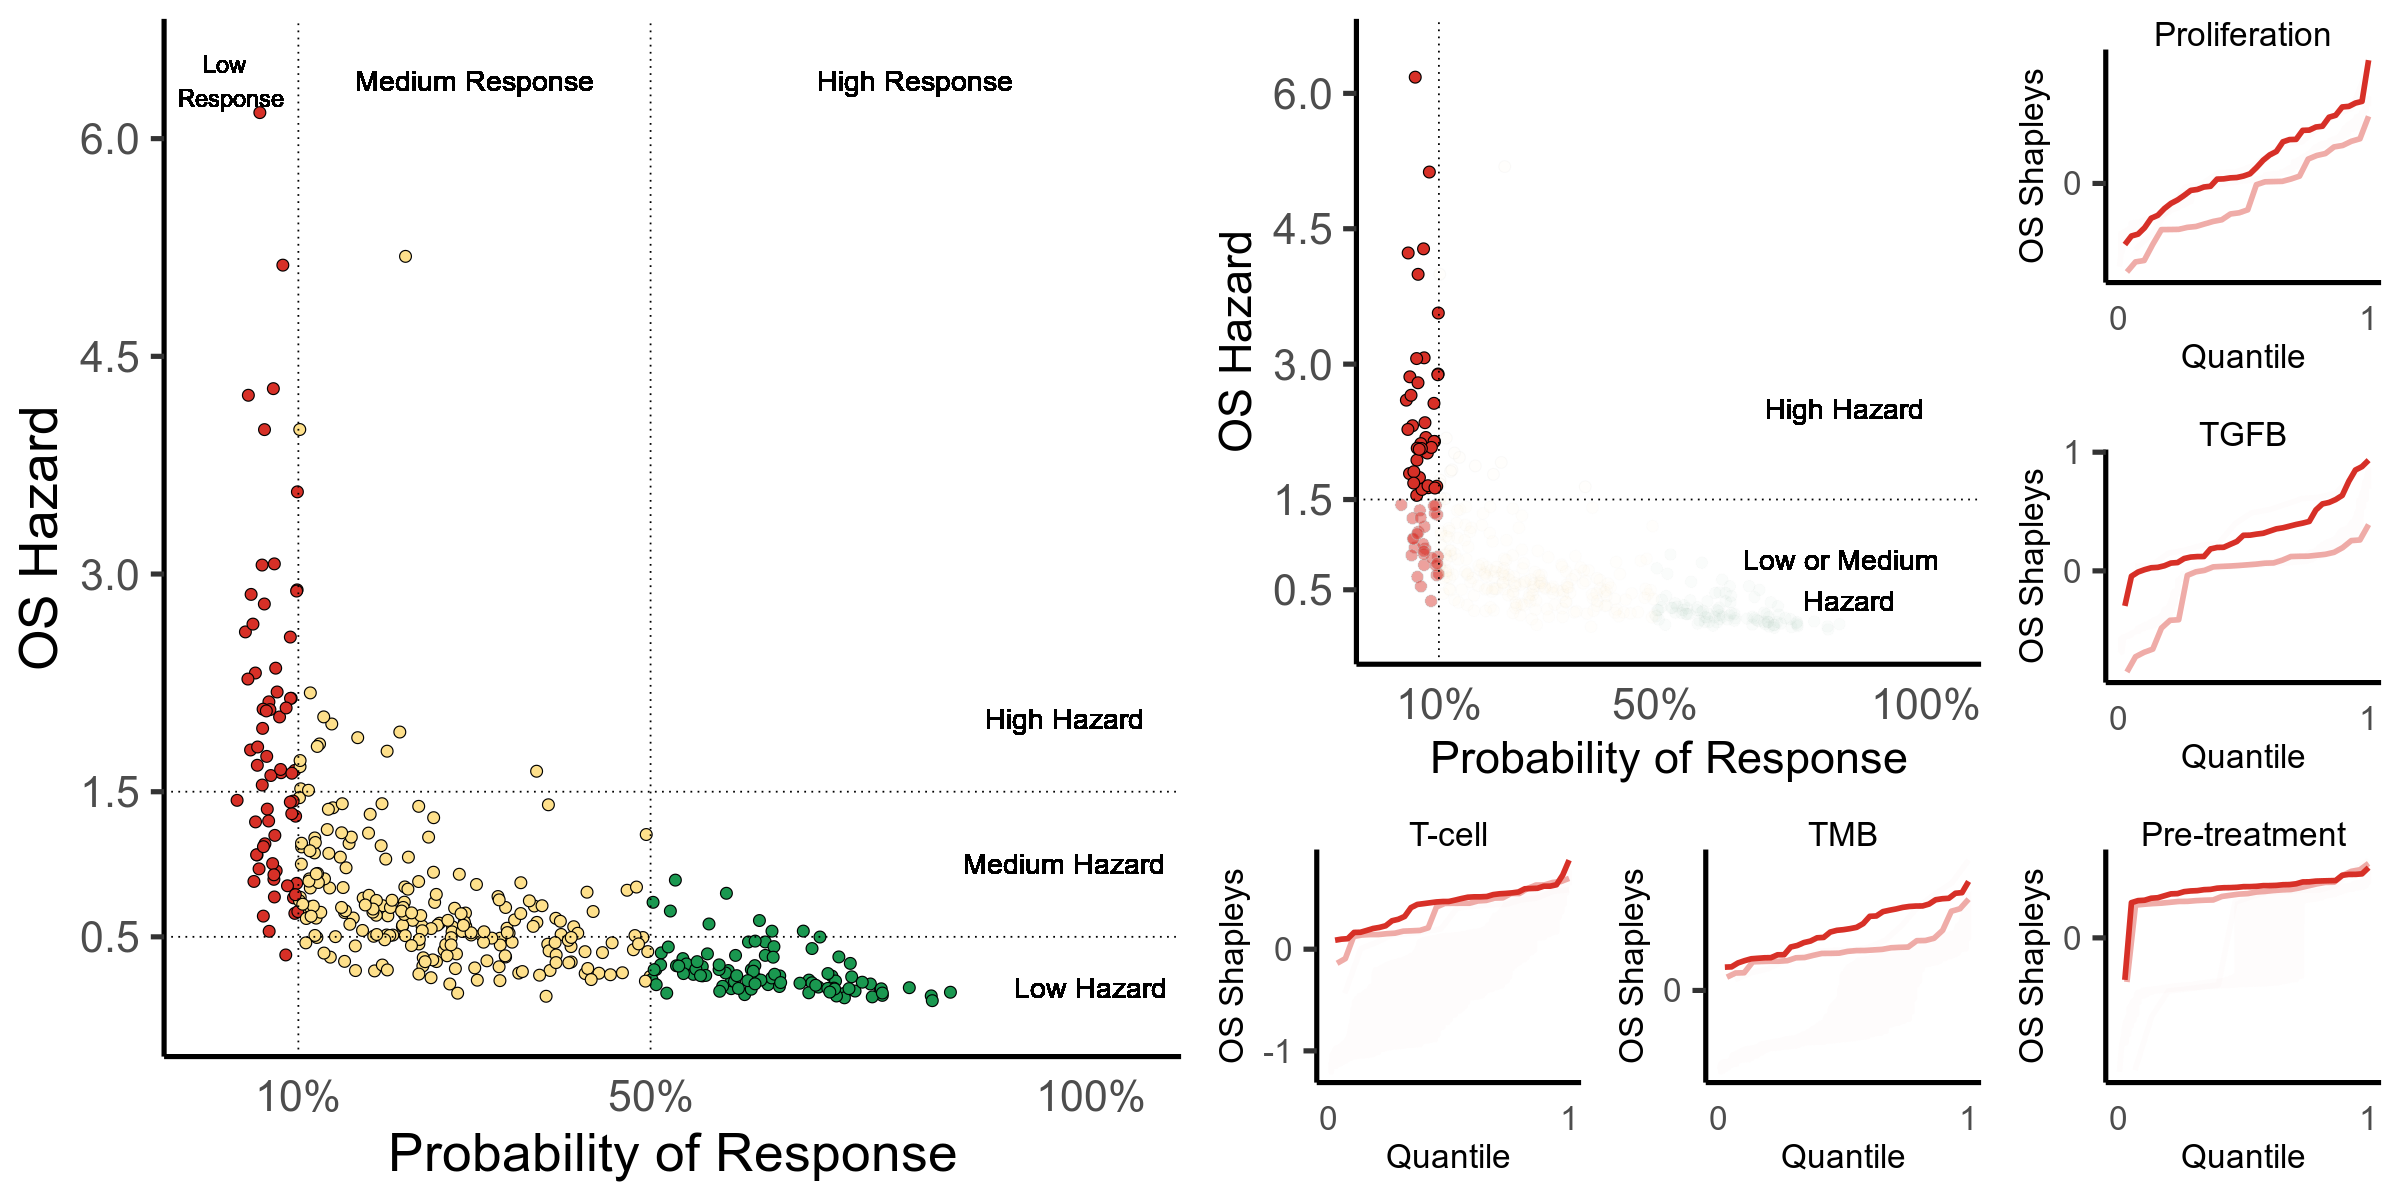

In [14]:
options(repr.plot.width=20, repr.plot.height=10, resolution = 200)
plot(together)

In [15]:
saveRDS( list( "e_main" = main, "low" = ready_low), file = paste0(FIG_DIR, "figure5_ef.Rds"))